# HDF5 file explorer

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy import signal

/Users/emilneby/miniforge3/envs/master/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
f = h5py.File('../Data/Halogaland_second_try.hdf5', 'r')
list(f.keys())

['2021-06-01-00-00-00', '2021-06-01-08-00-00', '2021-06-01-16-00-00']

In [15]:
morning_data = f['2021-06-01-00-00-00']
day_data = f['2021-06-01-08-00-00']
evening_data = f['2021-06-01-16-00-00']

In [16]:
print(list(morning_data.keys()))
print(type(morning_data))

['force_balance_accelerometers', 'piezoelectric_accelerometers', 'strain', 'temperature', 'wind']
<class 'h5py._hl.group.Group'>


In [17]:
acceleration_data = morning_data['force_balance_accelerometers']

In [18]:
acc_keys = (list(acceleration_data.keys()))
print(acc_keys)
if 'A07-1' in acc_keys: acc_keys.remove('A07-1')
print(acc_keys)
print((list(acceleration_data.keys())))
print(type(list(acceleration_data)))

['A01-1', 'A03-1', 'A03-2', 'A04-1', 'A04-2', 'A05-1', 'A05-2', 'A06-1', 'A06-2', 'A06-3', 'A06-4', 'A07-1', 'A07-2', 'A08-1', 'A08-2', 'A08-3', 'A08-4', 'A09-1', 'A09-2', 'A10-1', 'A10-2', 'A11-1']
['A01-1', 'A03-1', 'A03-2', 'A04-1', 'A04-2', 'A05-1', 'A05-2', 'A06-1', 'A06-2', 'A06-3', 'A06-4', 'A07-2', 'A08-1', 'A08-2', 'A08-3', 'A08-4', 'A09-1', 'A09-2', 'A10-1', 'A10-2', 'A11-1']
['A01-1', 'A03-1', 'A03-2', 'A04-1', 'A04-2', 'A05-1', 'A05-2', 'A06-1', 'A06-2', 'A06-3', 'A06-4', 'A07-1', 'A07-2', 'A08-1', 'A08-2', 'A08-3', 'A08-4', 'A09-1', 'A09-2', 'A10-1', 'A10-2', 'A11-1']
<class 'list'>


In [8]:
a07_1 = acceleration_data['A07-1']

In [9]:
print(list(a07_1.keys()))
print(type(a07_1))
attributes = (a07_1.attrs)
print(attributes.keys())

['x', 'y', 'z']
<class 'h5py._hl.group.Group'>
<KeysViewHDF5 ['location', 'position', 'samplerate', 'start_time', 'transformation_matrix', 'type']>


In [10]:
print(attributes['samplerate'])

16.0


In [11]:
x = a07_1['y']

In [12]:
print(type(x))

<class 'h5py._hl.dataset.Dataset'>


In [13]:
x = np.array(x)
print(len(x))

460800


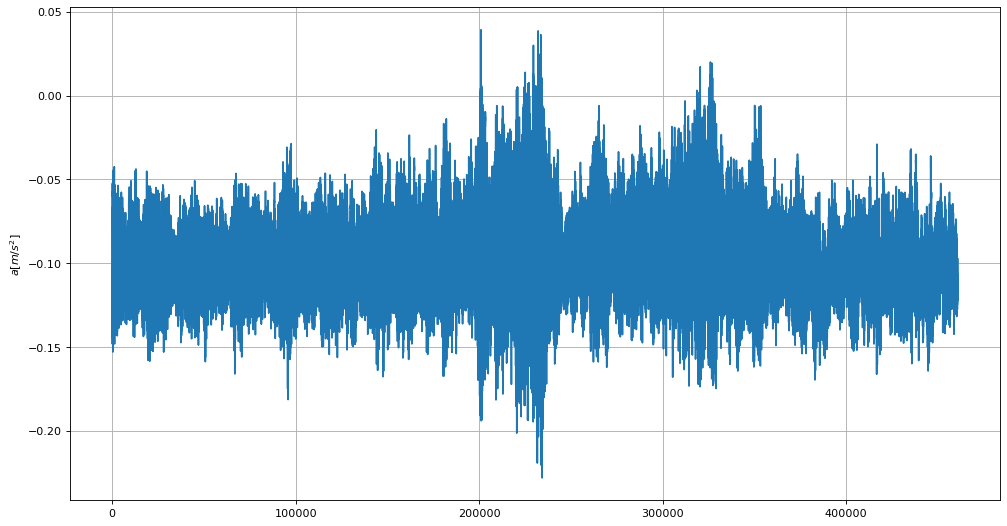

In [14]:
plt.figure(figsize=(15, 8), dpi=80)
plt.plot(x[:])
plt.ylabel('$a [m/s^2]$')
plt.grid()
plt.show()

### Acceleration spectrum from Welch's method

16.0
4097


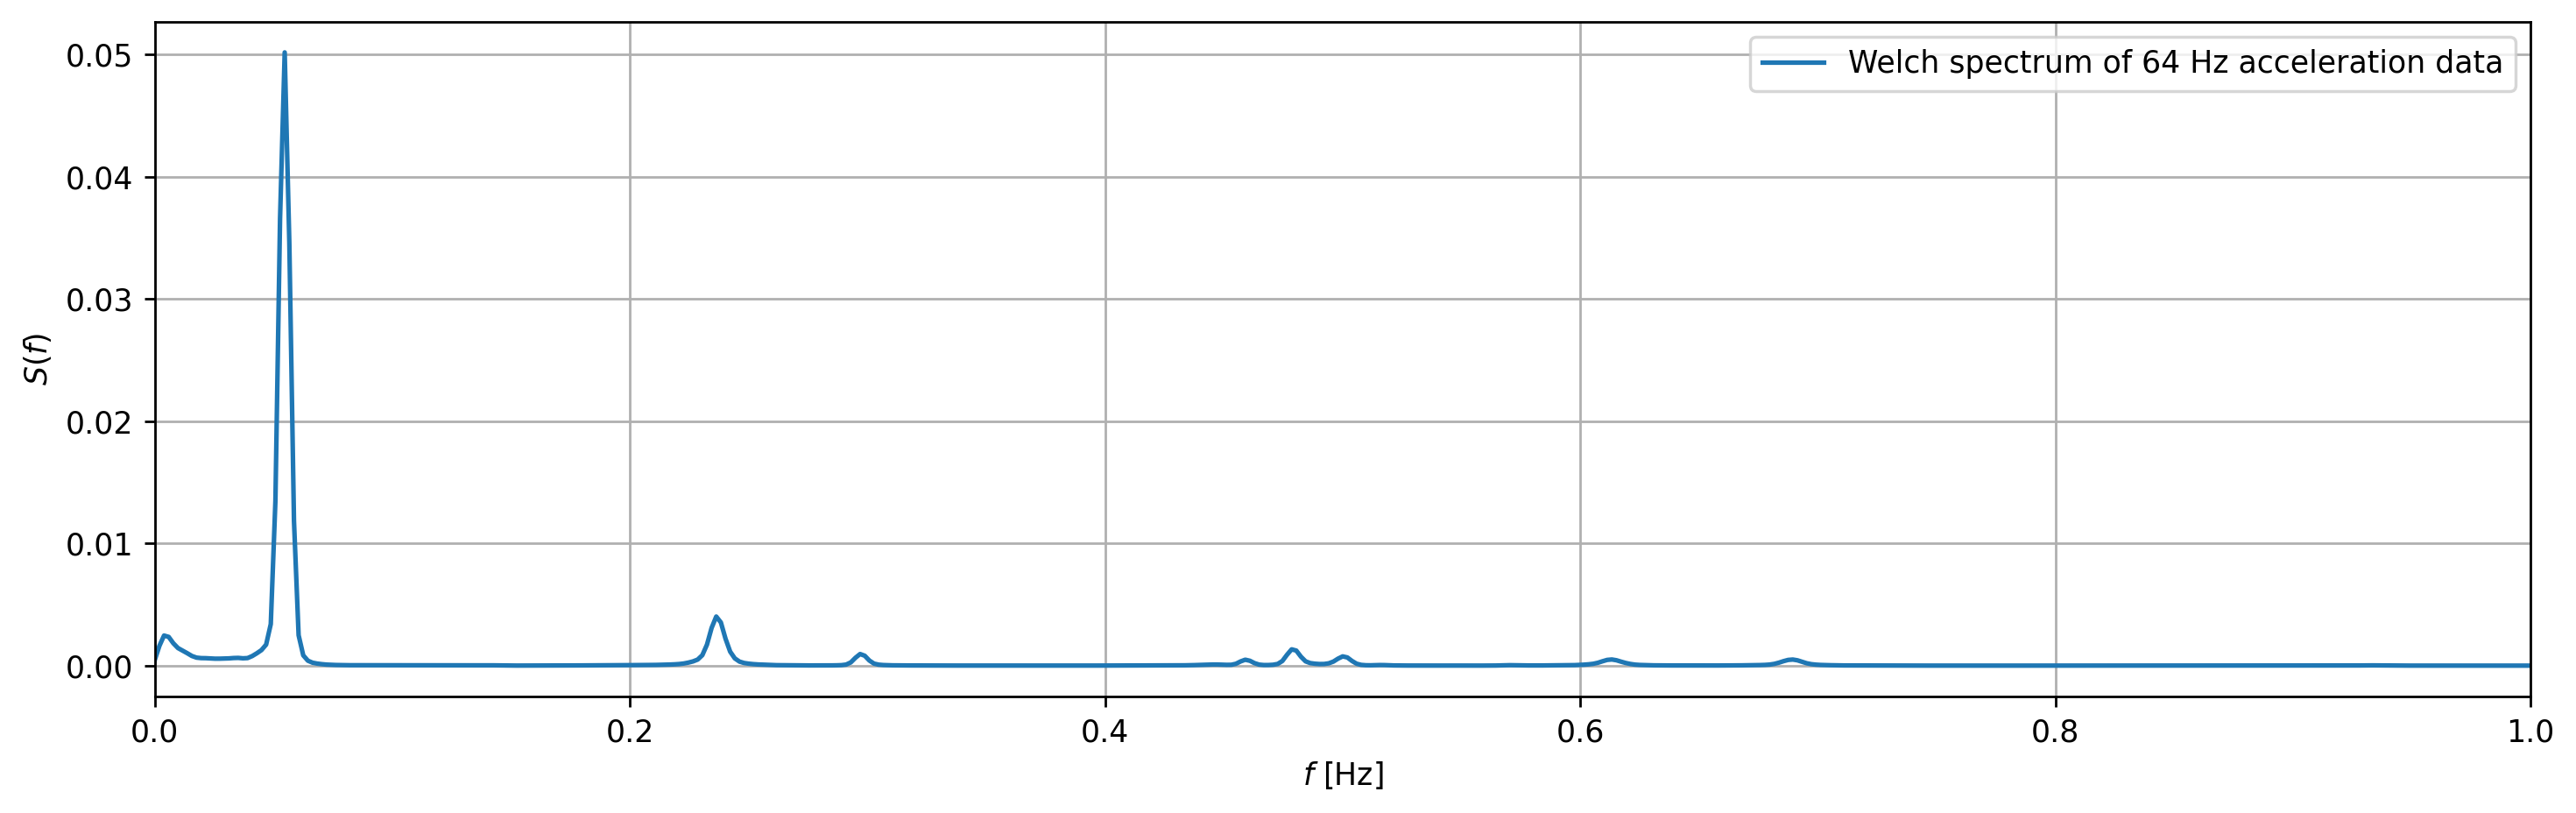

In [15]:
Ndivisions=100 # Number of divisions of the time series (total segments)
Nwindow=np.ceil(len(x)/Ndivisions) # Length of window/segment

sampling_frequency = attributes['samplerate']

Nfft_pow2 = 2**(np.ceil(np.log2(Nwindow))) # Next power of 2 for zero padding
dt=1/sampling_frequency# Time step
print(1/dt)

# Call welch from scipy signal processing
f, Sx_welch=signal.welch(x, fs=1/dt, window='hann', nperseg=Nwindow, noverlap=None, nfft=Nfft_pow2, detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')

print(len(f))
plt.figure(figsize=(14,4), dpi= 250)
plt.plot(f,Sx_welch,label = 'Welch spectrum of 64 Hz acceleration data')
plt.xlabel('$f$ [Hz]')
plt.ylabel('$S(f)$')#
plt.xlim([0,1])
#plt.yscale('log')
plt.grid()
plt.legend()
plt.savefig("welch_acceleration_freq_0-5_Hz.jpg")

### Constructing the auto correlation function

0.0625
16.0
0.0625
8192


/Users/emilneby/miniforge3/envs/master/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


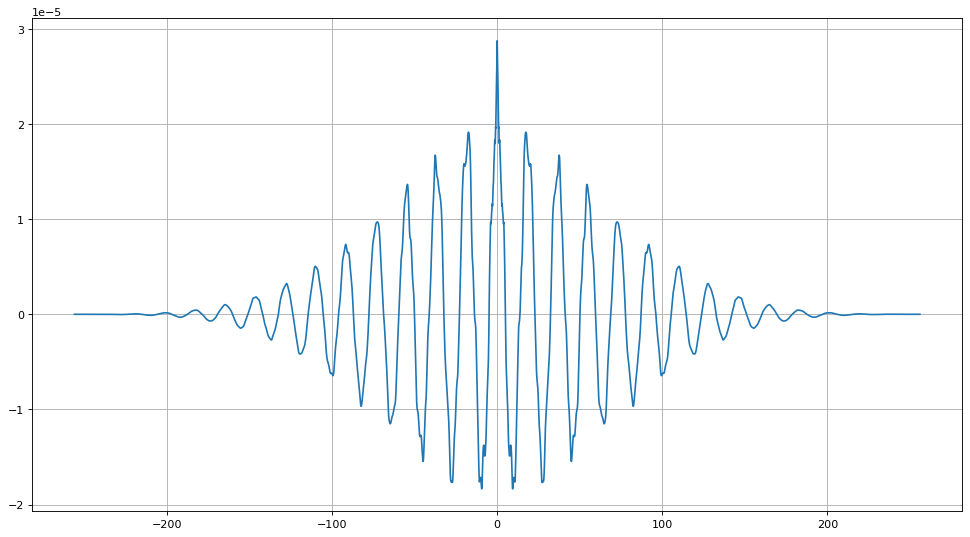

In [16]:
fi, Sx_welch=signal.welch(x, fs=1/dt, window='hann', nperseg=Nwindow, noverlap=None, nfft=Nfft_pow2, detrend='constant', return_onesided=False, scaling='density', axis=- 1, average='mean')
print(dt)
print(1/dt)
var = np.var(x)
acorr = np.fft.ifft(Sx_welch) #/var/len(acc['1y'])
acorr = np.fft.fftshift(acorr)
time_lag = np.arange(0,len(acorr))*dt
time_lag = time_lag - np.average(time_lag)
print(time_lag[-1]-time_lag[-2])

#acorr = acorr[time_lag>0]
#time_lag = time_lag[time_lag>0]

print(len(time_lag))

plt.figure(figsize=(15, 8), dpi=80)
plt.plot(time_lag, (acorr))
plt.grid()
#plt.xlim([0, 50])

(0.0, 50.0)

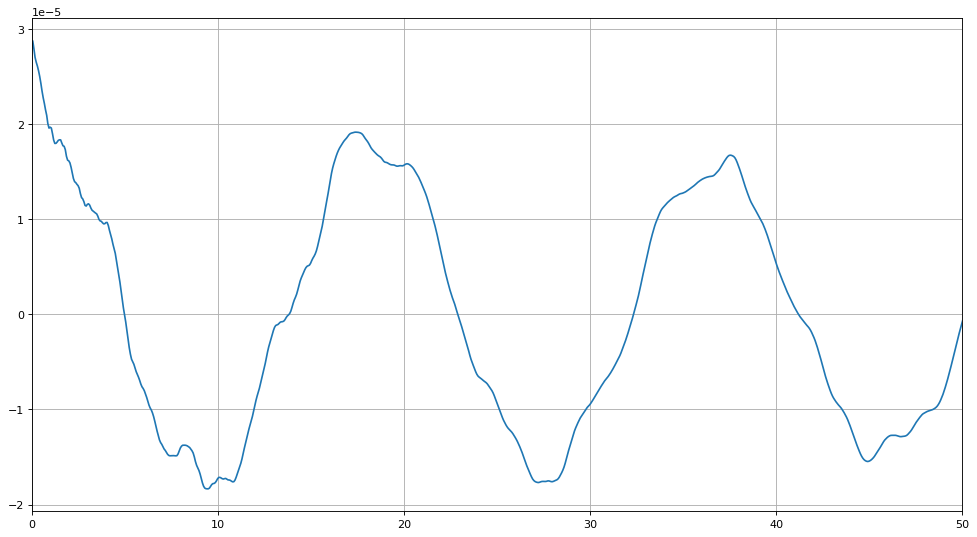

In [17]:
plt.figure(figsize=(15, 8), dpi=80)
plt.plot(time_lag, (acorr))
plt.grid()
plt.xlim([0, 50])

### Applying a Butterworth filter as a lowpass filter

16.0


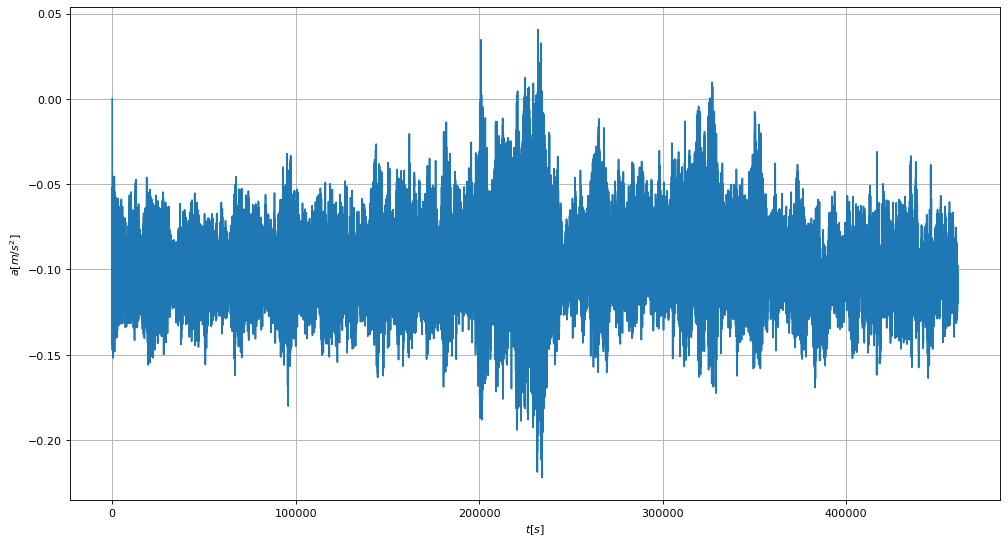

In [18]:
filter_order = 10
sampling_frequency = 1/dt
cutoff_frequency = 2


print(sampling_frequency)

sos = signal.butter(filter_order,cutoff_frequency,"lowpass", fs=sampling_frequency, output='sos')

filtered_acc = signal.sosfilt(sos, x)

plt.figure(figsize=(15, 8), dpi=80)
plt.plot( filtered_acc)
plt.xlabel('$t [s]$')
plt.ylabel('$a [m/s^2]$')
plt.grid()
plt.show()

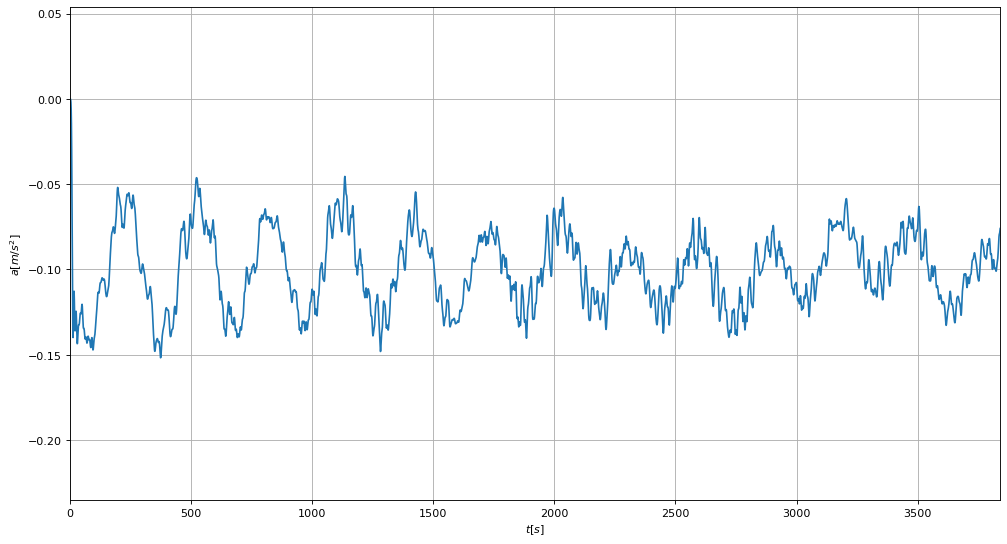

In [19]:
min = 1
plt.figure(figsize=(15, 8), dpi=80)
plt.plot( filtered_acc)
plt.xlabel('$t [s]$')
plt.ylabel('$a [m/s^2]$')
plt.grid()
plt.xlim(0, 64*60)
plt.show()

4097


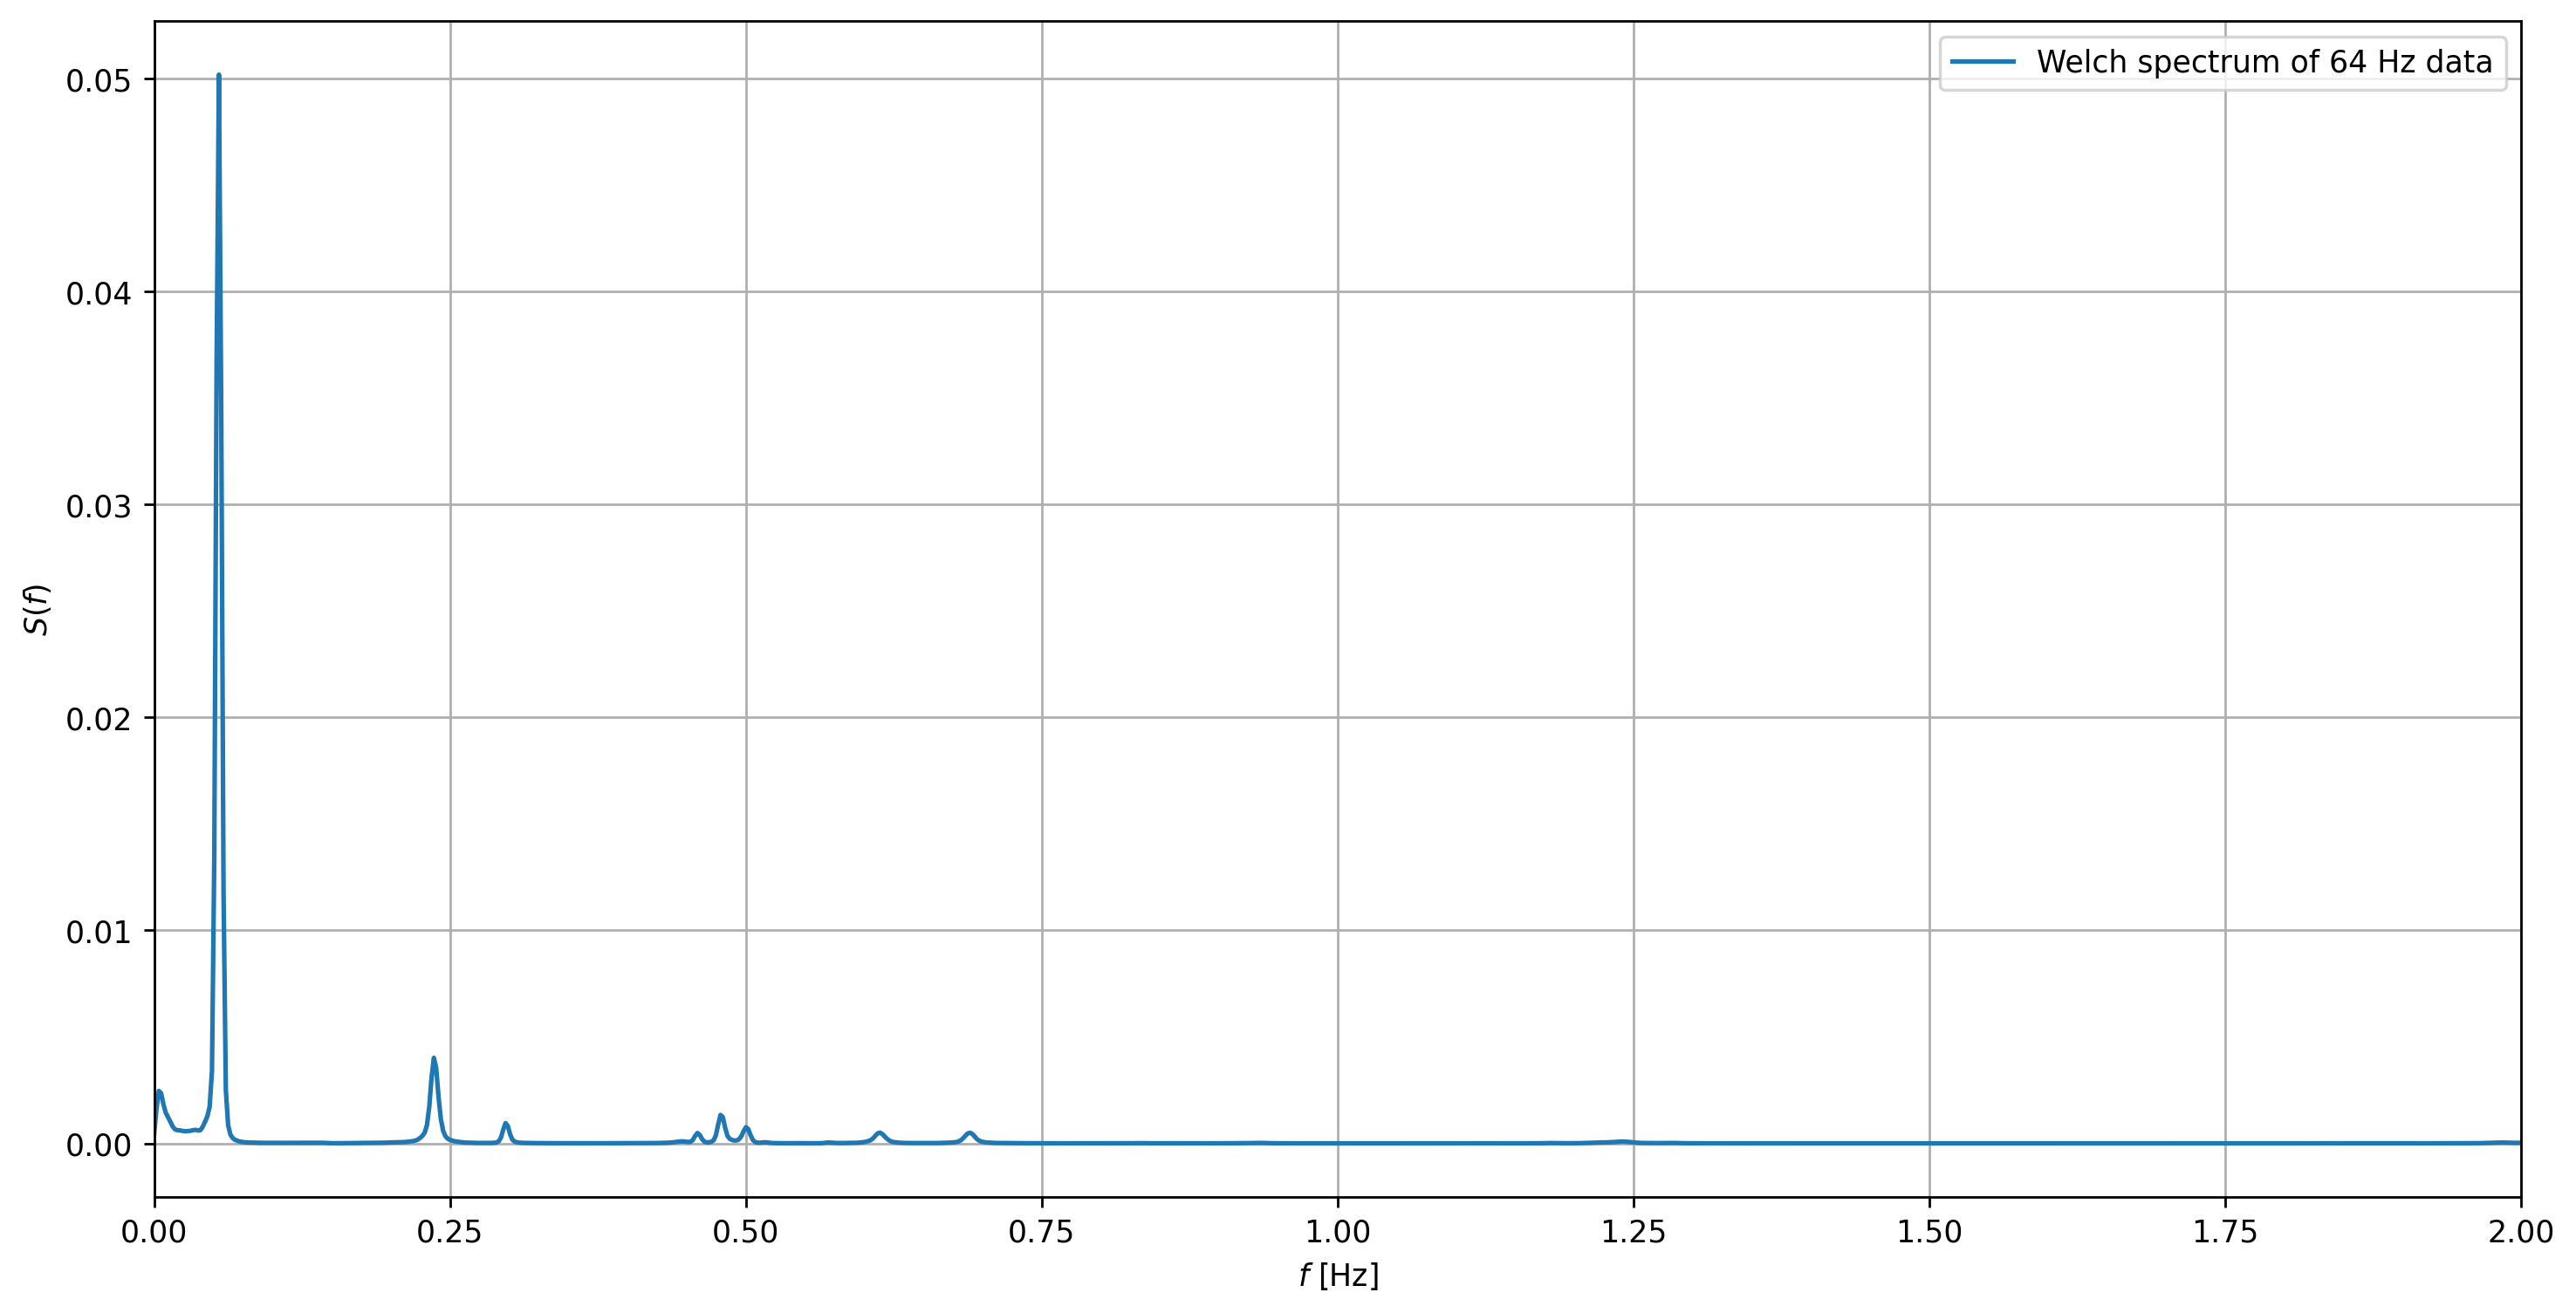

In [20]:
Ndivisions=100 # Number of divisions of the time series (total segments)
Nwindow=np.ceil(len(x)/Ndivisions) # Length of window/segment

Nfft_pow2 = 2**(np.ceil(np.log2(Nwindow))) # Next power of 2 for zero padding
dt=1/sampling_frequency # Time step

# Call welch from scipy signal processing
f, Sx_welch=signal.welch(filtered_acc, fs=1/dt, window='hann', nperseg=Nwindow, noverlap=None, nfft=Nfft_pow2, detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')

print(len(f))
# Plot and compare with exact solution
plt.figure(figsize=(14,7), dpi= 250)
plt.plot(f,Sx_welch,label = 'Welch spectrum of 64 Hz data')
plt.xlabel('$f$ [Hz]')
plt.ylabel('$S(f)$')
#plt.yscale('symlog')
plt.xlim([0,2])
plt.grid()
plt.legend()
plt.savefig("welch_acceleration_freq_0-5_Hz.jpg")

/Users/emilneby/miniforge3/envs/master/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


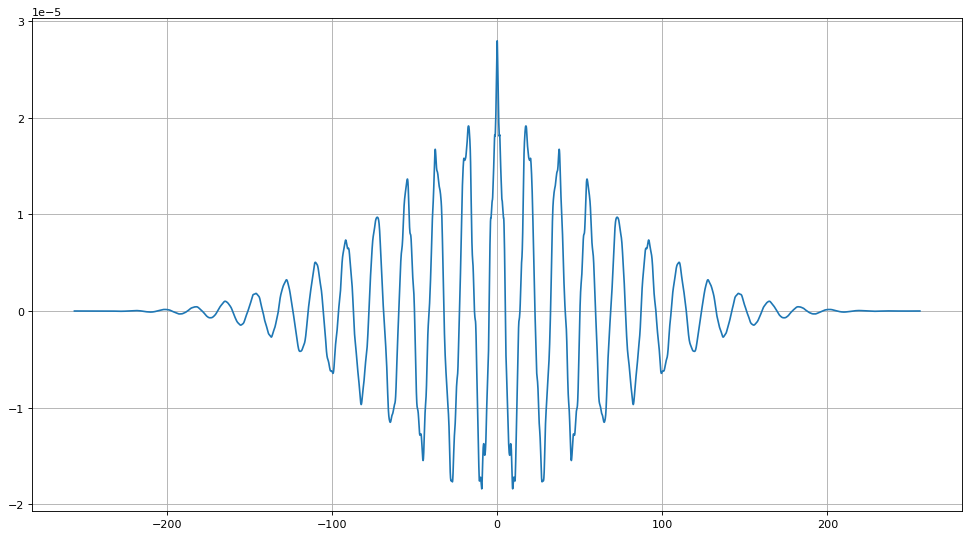

In [21]:
fi, Sx_welch=signal.welch(filtered_acc, fs=1/dt, window='hann', nperseg=Nwindow, noverlap=None, nfft=Nfft_pow2, detrend='constant', return_onesided=False, scaling='density', axis=- 1, average='mean')

var = np.var(filtered_acc)
acorr_filtered = np.fft.ifft(Sx_welch)
acorr_filtered = np.fft.fftshift(acorr_filtered)
time_lag = np.arange(0,len(acorr))*dt
time_lag = time_lag - np.average(time_lag)

plt.figure(figsize=(15, 8), dpi=80)
plt.plot(time_lag, (acorr_filtered))
plt.grid()
#plt.xlim([0, 50])

(0.0, 50.0)

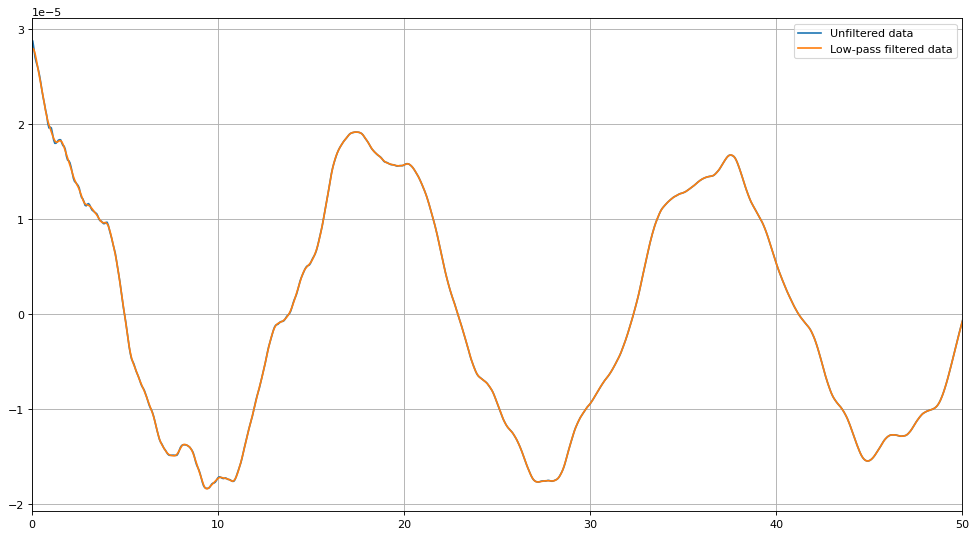

In [22]:
plt.figure(figsize=(15, 8), dpi=80)
plt.plot(time_lag, (acorr), label = 'Unfiltered data')
plt.plot(time_lag, (acorr_filtered), label = 'Low-pass filtered data')
plt.legend()
plt.grid()
plt.xlim([0, 50])

### Downsampling

In [23]:
x = np.linspace(0,10)
#print((x))

sampling_frequency_new = 4
factor = int(sampling_frequency/sampling_frequency_new)
print("Downsampling factor: " + str(factor))

down_sampled_acc = filtered_acc[::factor]


Downsampling factor: 4


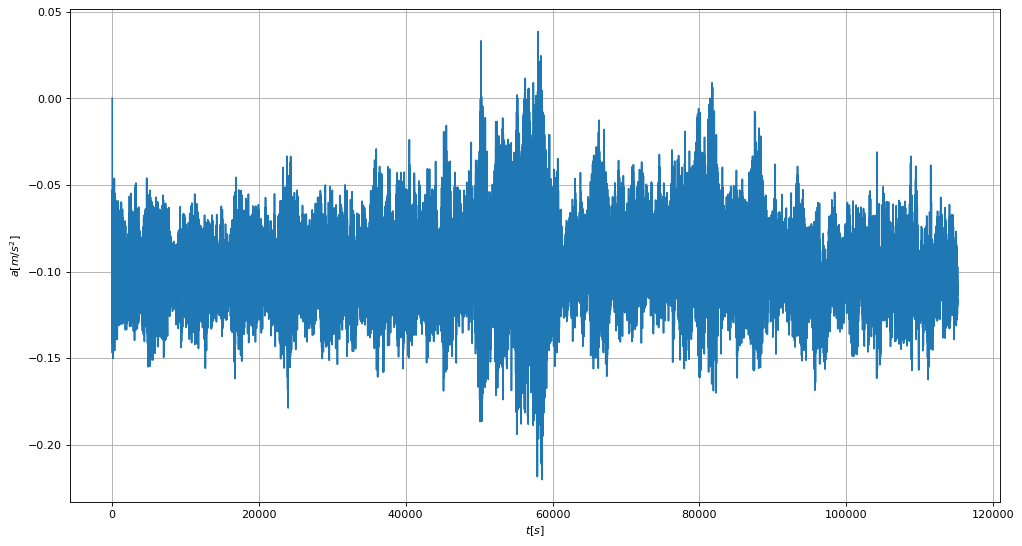

In [24]:
plt.figure(figsize=(15, 8), dpi=80)
plt.plot( down_sampled_acc)
plt.xlabel('$t [s]$')
plt.ylabel('$a [m/s^2]$')
plt.grid()
plt.show()

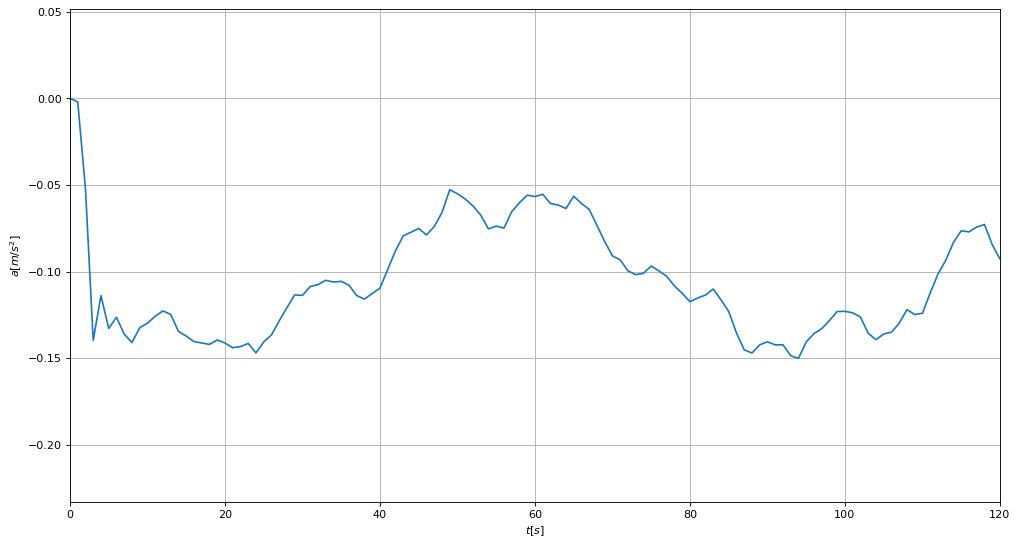

In [25]:
plt.figure(figsize=(15, 8), dpi=80)
plt.plot( down_sampled_acc)
plt.xlabel('$t [s]$')
plt.ylabel('$a [m/s^2]$')
plt.grid()
plt.xlim([0, 60*2])
plt.show()

4
1025


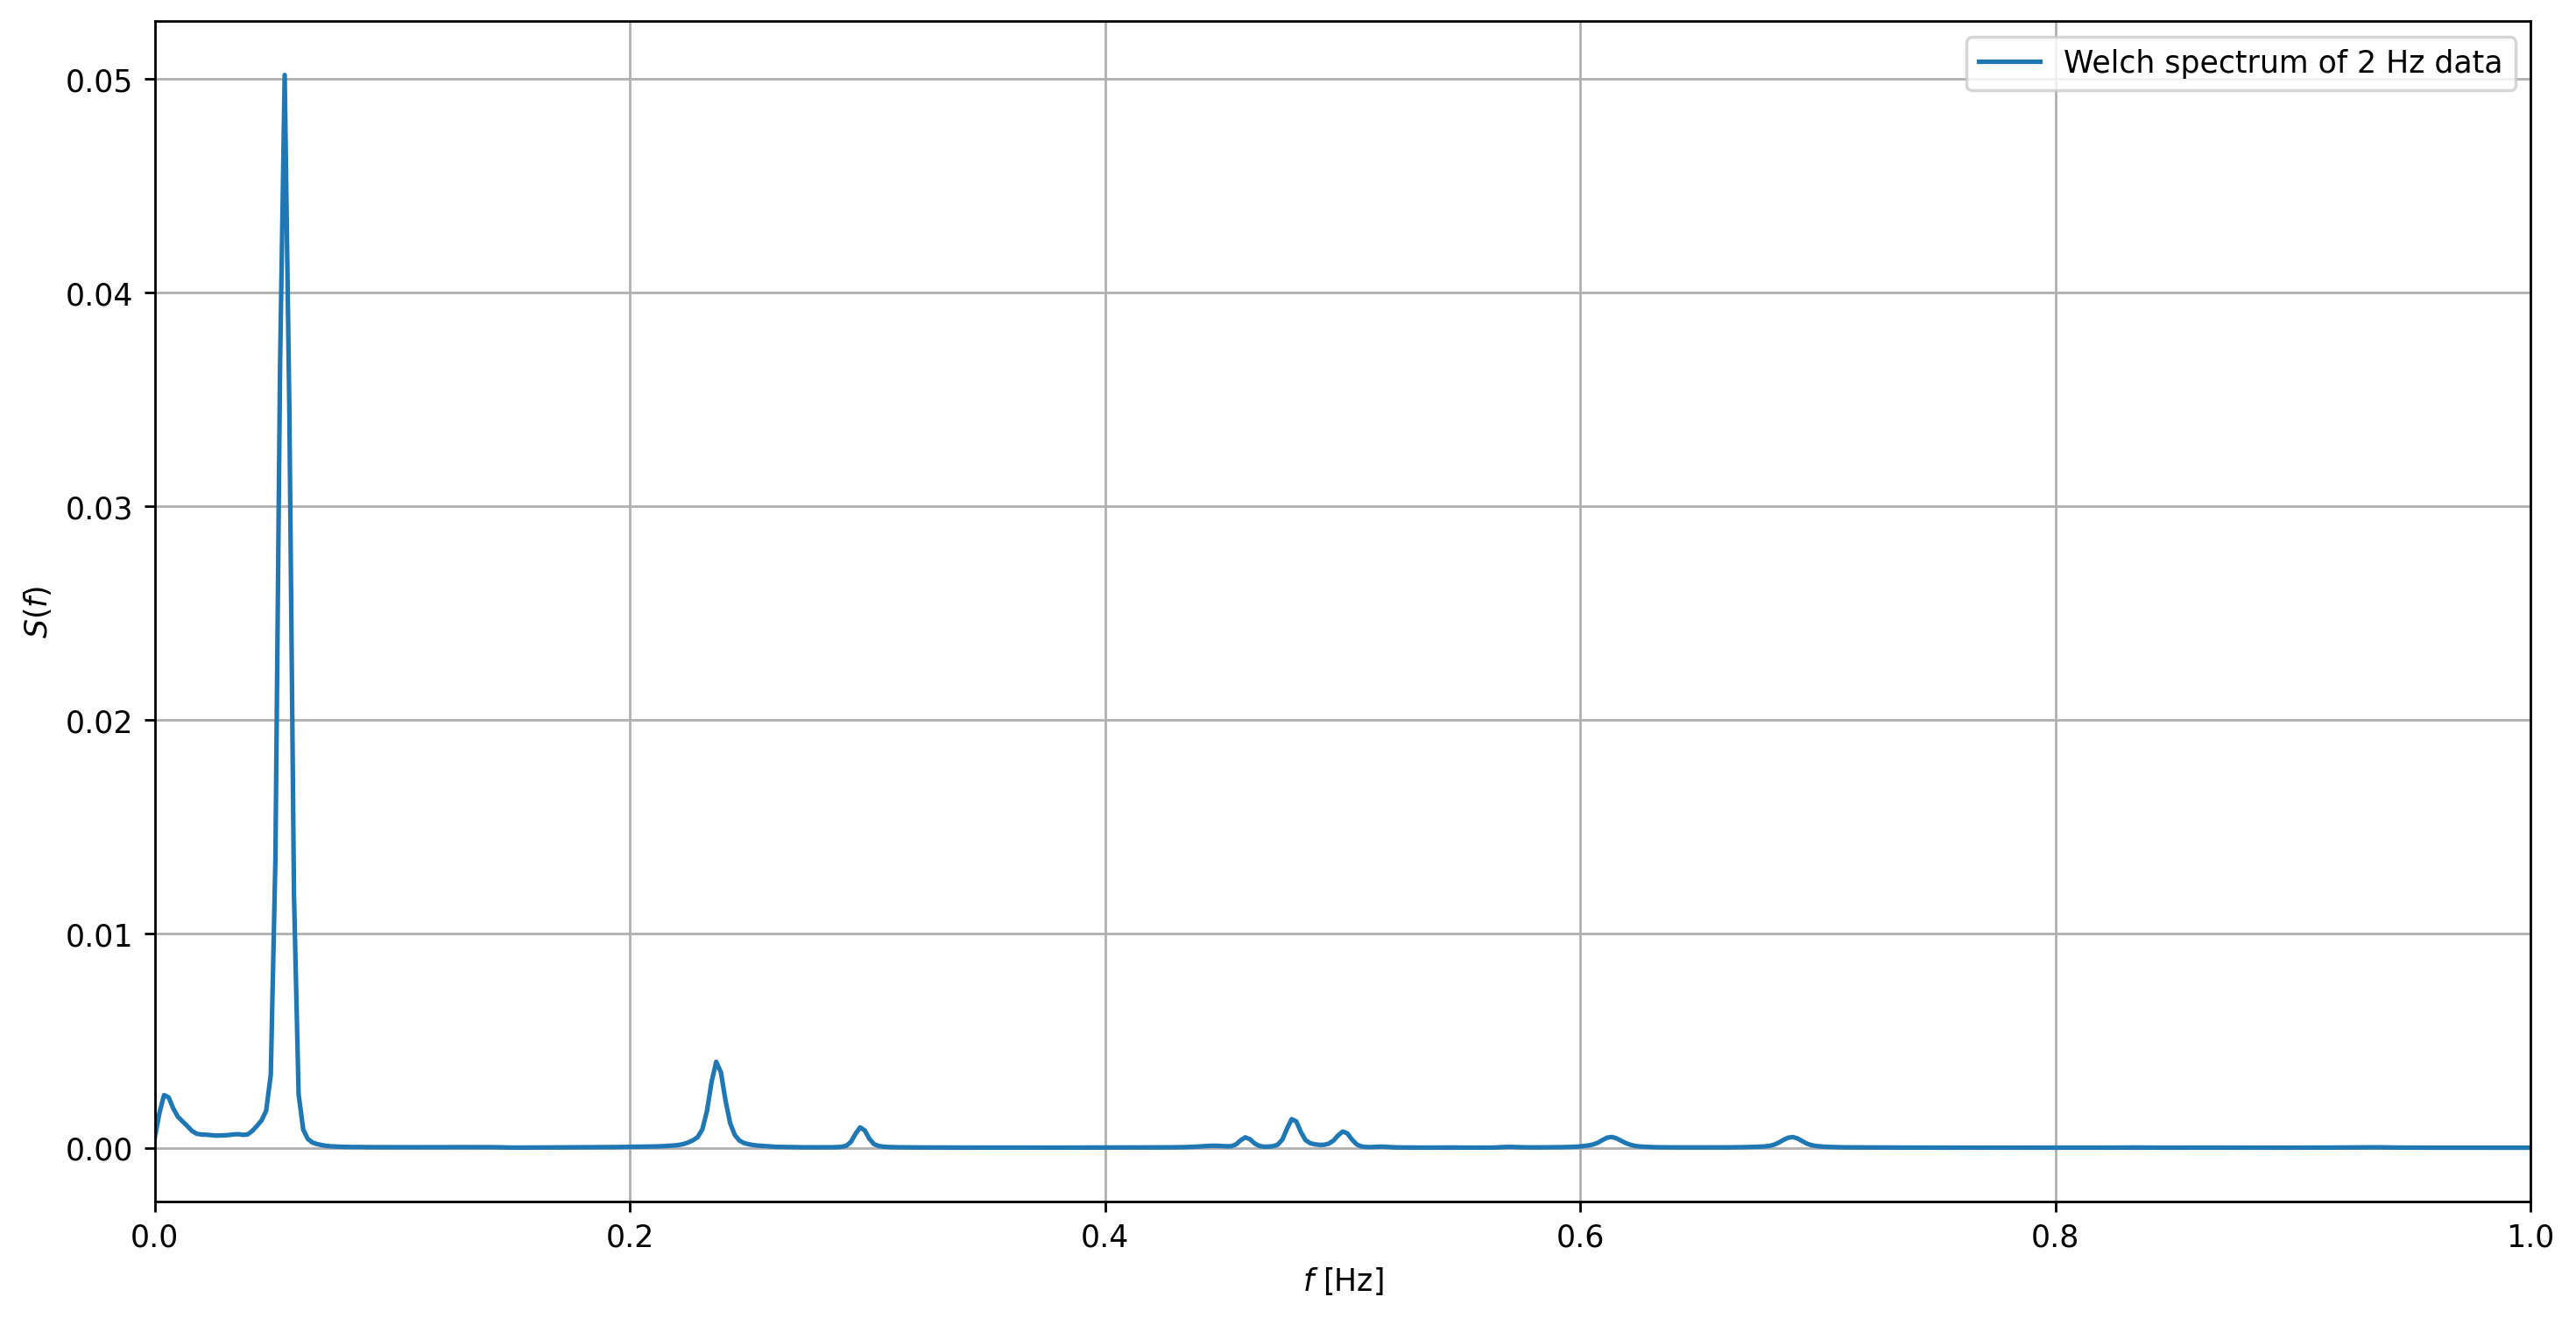

In [26]:
Ndivisions=100 # Number of divisions of the time series (total segments)
Nwindow=np.ceil(len(down_sampled_acc)/Ndivisions) # Length of window/segment

Nfft_pow2 = 2**(np.ceil(np.log2(Nwindow))) # Next power of 2 for zero padding
dt=1/sampling_frequency_new # Time step
print(int(1/dt))

# Call welch from scipy signal processing
f, Sx_welch=signal.welch(down_sampled_acc, fs=1/dt, window='hann', nperseg=Nwindow, noverlap=None, nfft=Nfft_pow2, detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')

print(len(f))
# Plot and compare with exact solution
plt.figure(figsize=(14,7), dpi= 250)
plt.plot(f,Sx_welch,label = 'Welch spectrum of 2 Hz data')
plt.xlabel('$f$ [Hz]')
plt.ylabel('$S(f)$')
#plt.yscale('symlog')
plt.xlim([0,1])
plt.grid()
plt.legend()

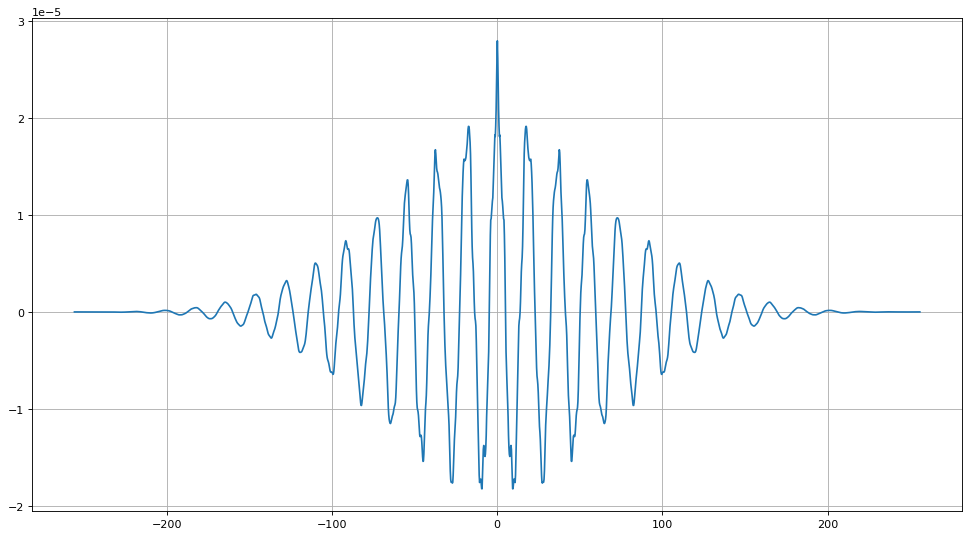

In [27]:
fi, Sx_welch=signal.welch(down_sampled_acc, fs=1/dt, window='hann', nperseg=Nwindow, noverlap=None, nfft=Nfft_pow2, detrend='constant', return_onesided=False, scaling='density', axis=- 1, average='mean')

var = np.var(down_sampled_acc)
acorr_down = np.fft.ifft(Sx_welch)
acorr_down = np.fft.fftshift(acorr_down)/factor
time_lag_down = np.arange(0,len(acorr_down))*dt
time_lag_down = time_lag_down - np.average(time_lag_down)

plt.figure(figsize=(15, 8), dpi=80)
plt.plot(time_lag_down, (acorr_down))
plt.grid()
#plt.xlim([0, 50])

(0.0, 50.0)

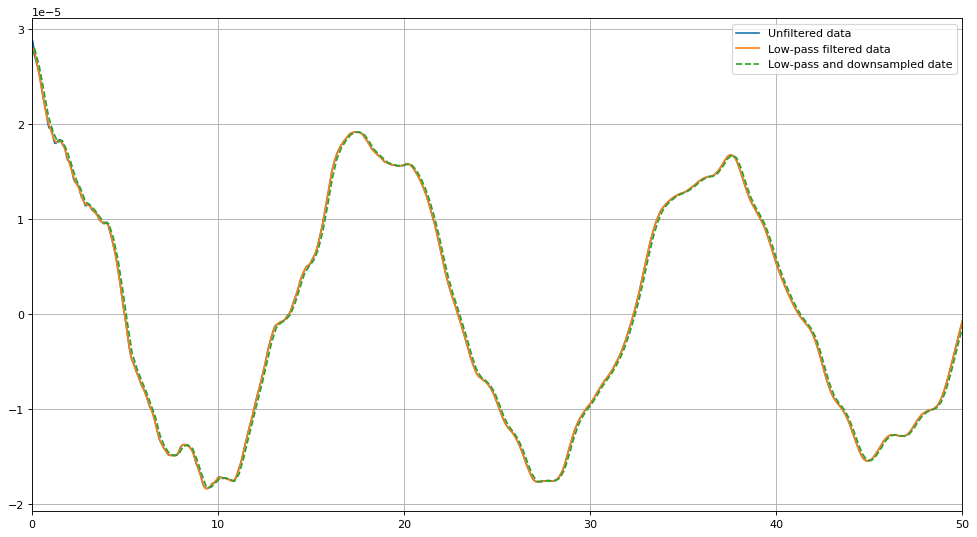

In [28]:
plt.figure(figsize=(15, 8), dpi=80)
plt.plot(time_lag, (acorr), label = 'Unfiltered data')
plt.plot(time_lag, (acorr_filtered), label = 'Low-pass filtered data')
plt.plot(time_lag_down, (acorr_down),  '--', label = 'Low-pass and downsampled date')
plt.legend()
plt.grid()
plt.xlim([0, 50])